In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from torch_tools import *
from wrappers import *
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 50
macro_configs = config_generator()
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

In [ ]:
root_name = 'RFLO_CDI_b200_50_examples_ctx0'
file_names = []
for params, i_seed in micro_configs:
    
    #if i_seed <= 48:
    #    continue
    
    np.random.seed(i_seed)
    T_trial = 100
    #task = Context_Dependent_Decision_Task(T_trial=T_trial, input_var=0.1, report_cue=True)
    task = Context_Dependent_Integration_Task(T_trial=T_trial, input_var=0.1)
    N_train = 1000000
    N_test = 20000
    checkpoint_interval = 10
    data = task.gen_data(N_train, N_test, add_dummy_end_point=False)
    batched_data = add_batch_dimension_to_data(data, T_trial)

    ### --- initialize RNN paramters and RNN object --- ###
    n_in = task.n_in
    n_hidden = 32
    n_out = task.n_out

    W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
    W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
    W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))
    b_rec = np.zeros(n_hidden)
    b_out = np.zeros(n_out)

    alpha = 0.1

    rnn = Torch_RNN(W_in, W_rec, W_out, b_rec, b_out,
                    activation='tanh',
                    alpha=alpha)
    
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
    scheduler = None
    checkpoints = train_torch_RNN_by_RFLO(rnn, optimizer, batched_data,
                                          batch_size=20, n_epochs=4,
                                          L2_reg=0.0001, verbose=True,
                                          checkpoint_interval=checkpoint_interval,
                                          scheduler=scheduler)
        
    sim = Empty_Simulation()
    sim.checkpoints = checkpoints
    indices = sorted([k for k in checkpoints.keys() if type(k) != str])
    sim.checkpoint_interval = indices[1] - indices[0]
    sim.total_time_steps = indices[-1] + sim.checkpoint_interval
    sim.rnn = checkpoints['final']['rnn']
    
    #fix context to context 0
    task.fixed_context = 0
    
    file_name = root_name + '_seed={}'.format(i_seed)
    for key in params.keys():
        file_name += '_{}={}'.format(key, str(params[key]).replace('.', ','))
        
    file_names.append(file_name)
    
    print('finish simulation: {}'.format(i_seed))
    for key in params.keys():
        print('{}:, {}, seed = {}'.format(key, params[key], i_seed))
    if np.isnan(rnn.W_rec.detach().numpy()[0, 0]):
        print('MISTAKES WERE MADE')
        break
    
    
    ### --- SAVE RUN --- ###
    with open(os.path.join('saved_runs/', file_name), 'wb') as f:
        saved_run = {'sim': sim, 'task': task}
        pickle.dump(saved_run, f)

Epoch 0, Batch 0
Loss 12.6830415725708
Epoch 0, Batch 50
Loss 0.5831945538520813
Epoch 0, Batch 100
Loss 0.8517913818359375
Epoch 0, Batch 150
Loss 0.6397455930709839
Epoch 0, Batch 200
Loss 0.3819768726825714
Epoch 0, Batch 250
Loss 0.35567134618759155
Epoch 0, Batch 300
Loss 0.3143549859523773
Epoch 0, Batch 350
Loss 0.09562838822603226
Epoch 0, Batch 400
Loss 0.1173303872346878
Epoch 0, Batch 450
Loss 0.14164434373378754
Epoch 1, Batch 0
Loss 0.05729437991976738
Epoch 1, Batch 50
Loss 0.03563522920012474
Epoch 1, Batch 100
Loss 0.03402932360768318
Epoch 1, Batch 150
Loss 0.025934873148798943
Epoch 1, Batch 200
Loss 0.0261800829321146
Epoch 1, Batch 250
Loss 0.03113212250173092
Epoch 1, Batch 300
Loss 0.03416361287236214


In [3]:
### --- Full cross-checkpoint analysis --- ###
root_name = 'RFLO_CDI_b200_50_examples_ctx0'
cross_topological_analysis(root_name, FP_find_FPs=True,
                           FP_KE_criterion=0.00001, FP_N=1000, ppn=16, compare_n_comp_window=1,
                           FP_context=np.eye(4)[2],
                           n_checkpoints_per_job_=50,
                           n_compare_hours=24,
                           compare_n_comp_jobs=1000,
                           compare_only=False,
                           compare_aligned_graph=False,
                           compare_node_drift=False,
                           compare_node_diff=False,
                           test_N=2000, test_save_data=False, compare_CKA=False,
                           compare_PC1=False, compare_PC2=False, compare_PC3=False,
                           compare_cross_param_ordering=['seed'],
                           results_subdir='PNAS_Paper')

rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_RFLO_CDI_b200_50_examples_ctx0_seed=0/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-r

vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Rever

sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
v

vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/State_Space_Analysis.py
vanilla-rtrl/plotting/__init__.py
vanilla-rtrl/plotting/checkpoint_plots.py
vanilla-rtrl/plotting/misc.py
vanilla-rtrl/te

vanilla-rtrl/dynamics/feature_space.py
vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/dynamics/topology.py
vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtr

vanilla-rtrl/test/test_network.py
vanilla-rtrl/test/test_optimizers.py
vanilla-rtrl/test/test_utils.py
vanilla-rtrl/torch_tools/
vanilla-rtrl/torch_tools/__init__.py
vanilla-rtrl/torch_tools/numpy_utils.py
vanilla-rtrl/torch_tools/torch_rnn.py
vanilla-rtrl/torch_tools/train.py
vanilla-rtrl/torch_tools/train_DNI.py
vanilla-rtrl/utils/
vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  301,590.67 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learn

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill

vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  180,954.40 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_RFLO_CDI_b200_50_examples_ctx0_seed=19/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_comp

vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
v

vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
vanilla-rtrl/continual_learning/
vanilla-rtrl/continual_learning/Continual_Learning.py
vanilla-rtrl/continual_learning/Duncker_Method.py
vanilla-rtrl/continual_learning/Synaptic_Intelligence.py
vanilla-rtrl/continual_learning/__init__.py
vanilla-rtrl/core/
vanilla-r

vanilla-rtrl/plotting/misc.py
vanilla-rtrl/test/
vanilla-rtrl/test/__init__.py
vanilla-rtrl/test/test_gen_data.py
vanilla-rtrl/test/test_learning_algorithms.py
vanilla-rtrl/test/test_network.py
vanilla-rtrl/test/test_optimizers.py
vanilla-rtrl/test/test_utils.py
vanilla-rtrl/torch_tools/
vanilla-rtrl/torch_tools/__init__.py
vanilla-rtrl/torch_tools/numpy_utils.py
vanilla-rtrl/torch_tools/torch_rnn.py
vanilla-rtrl/torch_tools/train.py
vanilla-rtrl/torch_tools/train_DNI.py
vanilla-rtrl/utils/
vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topo

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill

vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  904,772.00 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_RFLO_CDI_b200_50_examples_ctx0_seed=26/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.

vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/State_Space_Analysis.py
vanilla-rtrl/plotting/__init__.py
vanilla-rtrl/plotting/checkpoint_plots.py
vanilla-rtrl/plotting/misc.py
vanilla-rtrl/te

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill

vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  904,772.00 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_RFLO_CDI_b200_50_examples_ctx0_seed=30/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConf

vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Rever

sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
v

vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/State_Space_Analysis.py
vanilla-rtrl/plotting/__init__.py
vanilla-rtrl/plotting/checkpoint_plots.py
vanilla-rtrl/plotting/misc.py
vanilla-rtrl/te

vanilla-rtrl/dynamics/dynamics_utils.py
vanilla-rtrl/dynamics/feature_space.py
vanilla-rtrl/dynamics/metrics.py
vanilla-rtrl/dynamics/topology.py
vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fi

vanilla-rtrl/test/test_network.py
vanilla-rtrl/test/test_optimizers.py
vanilla-rtrl/test/test_utils.py
vanilla-rtrl/torch_tools/
vanilla-rtrl/torch_tools/__init__.py
vanilla-rtrl/torch_tools/numpy_utils.py
vanilla-rtrl/torch_tools/torch_rnn.py
vanilla-rtrl/torch_tools/train.py
vanilla-rtrl/torch_tools/train_DNI.py
vanilla-rtrl/utils/
vanilla-rtrl/utils/__init__.py
vanilla-rtrl/utils/mathematical_tools.py
vanilla-rtrl/utils/programming_tools.py
vanilla-rtrl/wrappers/
vanilla-rtrl/wrappers/__init__.py
vanilla-rtrl/wrappers/analyze_individual_checkpoint.py
vanilla-rtrl/wrappers/analyze_training_run.py
vanilla-rtrl/wrappers/compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  301,590.67 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learn

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill

vanilla-rtrl/wrappers/cross_compare_analyzed_checkpoints.py
vanilla-rtrl/wrappers/cross_topological_analysis.py
vanilla-rtrl/wrappers/get_default_args.py
vanilla-rtrl/wrappers/topological_analysis.py

sent 450,035 bytes  received 2,351 bytes  301,590.67 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_RFLO_CDI_b200_50_examples_ctx0_seed=40/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConf

vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Rever

sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/cluster/
vanilla-rtrl/cluster/__init__.py
vanilla-rtrl/cluster/close_jupyter_notebook.py
vanilla-rtrl/cluster/process_results.py
vanilla-rtrl/cluster/start_jupyter_notebook.py
vanilla-rtrl/cluster/submit_jobs.py
vanilla-rtrl/cluster/sync_cluster.py
v

vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/State_Space_Analysis.py
vanilla-rtrl/plotting/__init__.py
vanilla-rtrl/plotting/checkpoint_plots.py
vanilla-rtrl/plotting/misc.py
vanilla-rtrl/te

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill


sent 450,035 bytes  received 2,351 bytes  904,772.00 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_RFLO_CDI_b200_50_examples_ctx0_seed=48/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla

vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Reverse_KF_RTRL.py
vanilla-rtrl/learning_algorithms/Stochastic_Algorithm.py
vanilla-rtrl/learning_algorithms/UORO.py
vanilla-rtrl/learning_algorithms/__init__.py
vanilla-rtrl/learning_algorithms/tmp.py
vanilla-rtrl/optimizers/
vanilla-rtrl/optimizers/Adam.py
vanilla-rtrl/optimizers/Optimizer.py
vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradie

vanilla-rtrl/dynamics/track_fixed_points.py
vanilla-rtrl/functions/
vanilla-rtrl/functions/Function.py
vanilla-rtrl/functions/__init__.py
vanilla-rtrl/functions/identity.py
vanilla-rtrl/functions/mean_squared_error.py
vanilla-rtrl/functions/relu.py
vanilla-rtrl/functions/sigmoid.py
vanilla-rtrl/functions/sigmoid_cross_entropy.py
vanilla-rtrl/functions/softmax.py
vanilla-rtrl/functions/softmax_cross_entropy.py
vanilla-rtrl/functions/softplus.py
vanilla-rtrl/functions/tanh.py
vanilla-rtrl/gen_data/
vanilla-rtrl/gen_data/Add_Task.py
vanilla-rtrl/gen_data/Binary_Addition_Task.py
vanilla-rtrl/gen_data/Context_Dependent_Integration_Task.py
vanilla-rtrl/gen_data/Cts_Integration_Task.py
vanilla-rtrl/gen_data/Delay_Nonmatch_Task.py
vanilla-rtrl/gen_data/Discrete_Integration_Task.py
vanilla-rtrl/gen_data/Embedded_Inputs_Task.py
vanilla-rtrl/gen_data/Fixed_Point_Transition_Task.py
vanilla-rtrl/gen_data/Flip_Flop_Task.py
vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanill


sent 450,035 bytes  received 2,351 bytes  301,590.67 bytes/sec
total size is 441,424  speedup is 0.98
rm: cannot remove ‘/home/om2382/learning-dynamics/results/PNAS_Paper/analyze_RFLO_CDI_b200_50_examples_ctx0_seed=8/result_*’: No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/.gitignore
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.idea/inspectionProfiles/
vanilla-rtrl/.idea/inspectionProfiles/profiles_settings.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-

vanilla-rtrl/gen_data/Mimic_RNN.py
vanilla-rtrl/gen_data/Multi_Task.py
vanilla-rtrl/gen_data/Sensorimotor_Mapping.py
vanilla-rtrl/gen_data/Sequential_MNIST.py
vanilla-rtrl/gen_data/Sine_Wave.py
vanilla-rtrl/gen_data/Task.py
vanilla-rtrl/gen_data/__init__.py
vanilla-rtrl/gen_data/gen_data_utils.py
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_algorithms/RTRL.py
vanilla-rtrl/learning_algorithms/Random_Noise_Gradients.py
vanilla-rtrl/learning_algorithms/Rever

In [5]:
!squeue -u om2382

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
     1133795_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133794_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133793_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133792_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133791_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133790_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133789_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133788_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133787_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133786_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133785_[1-4] lkumar,bu analyze_   om2382 PD       0:00      1 (Priority)
     1133784_[1-4] lkumar,bu analyze_   om2382

In [4]:
!ls saved_runs/

BPTT_50_examples_ctx0_seed=0   BPTT_examples_ctx0_seed=5
BPTT_50_examples_ctx0_seed=1   BPTT_examples_ctx0_seed=6
BPTT_50_examples_ctx0_seed=10  BPTT_examples_ctx0_seed=7
BPTT_50_examples_ctx0_seed=11  BPTT_examples_ctx0_seed=8
BPTT_50_examples_ctx0_seed=12  BPTT_examples_ctx0_seed=9
BPTT_50_examples_ctx0_seed=13  RFLO_50_examples_ctx0_seed=0
BPTT_50_examples_ctx0_seed=14  RFLO_50_examples_ctx0_seed=1
BPTT_50_examples_ctx0_seed=15  RFLO_50_examples_ctx0_seed=10
BPTT_50_examples_ctx0_seed=16  RFLO_50_examples_ctx0_seed=11
BPTT_50_examples_ctx0_seed=17  RFLO_50_examples_ctx0_seed=12
BPTT_50_examples_ctx0_seed=18  RFLO_50_examples_ctx0_seed=13
BPTT_50_examples_ctx0_seed=19  RFLO_50_examples_ctx0_seed=14
BPTT_50_examples_ctx0_seed=2   RFLO_50_examples_ctx0_seed=15
BPTT_50_examples_ctx0_seed=20  RFLO_50_examples_ctx0_seed=16
BPTT_50_examples_ctx0_seed=21  RFLO_50_examples_ctx0_seed=17
BPTT_50_examples_ctx0_seed=22  RFLO_50_examples_ctx0_seed=18
BPTT_50_examples_ctx0_seed=23  RFLO_50_example

In [5]:
root_name = 'RFLO_50_examples_ctx0'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                'n_nodes': get_checkpoint_n_stable_FPs,
                                                                                'discriminant': get_checkpoint_cubic_discriminant,
                                                                                'lengths': get_checkpoint_maximum_cluster_distances},
                                                   results_subdir='PNAS_Paper',
                                                   multi_job_comp=True)

In [ ]:
root_name = 'length_test_loss'
signal_dicts_0, result_0 = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                   'n_nodes': get_checkpoint_n_stable_FPs,
                                                                                   'discriminant': get_checkpoint_cubic_discriminant,
                                                                                   'lengths': get_checkpoint_maximum_cluster_distances},
                                                       results_subdir='misc',
                                                       multi_job_comp=True)

In [ ]:
!rm ../results/misc/cross_compare_length_testloss_lr/result_combined

In [ ]:
root_name = 'three_geo_algs'
signal_geo_dicts, geo_result = unpack_cross_compare_result(root_name,
                                                           results_subdir='PNAS_Paper',
                                                           multi_job_comp=True)

In [ ]:
M = result['rec_weight_distances']
M = M + M.T
plt.figure(figsize=(11, 11))
plt.imshow(M)

In [ ]:
checkpoints['checkpoint_0'].keys()

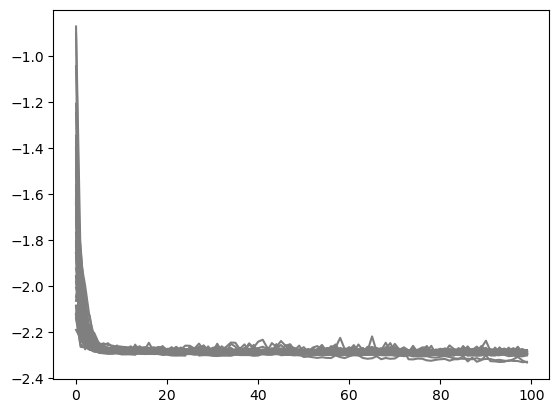

In [6]:
for key in signal_dicts.keys():
    plt.plot(np.log10(signal_dicts[key]['test_loss']), color='C7')

In [ ]:
root_name = 'length_testloss_lr'
results_dir = '/home/om2382/learning-dynamics/results/misc'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts_0 = {}
for job_name in analysis_jobs:
    indices_0, checkpoints_0 = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts_0[job_name] = {'indices': indices_0,
                                     'checkpoints': checkpoints_0}

In [ ]:
root_name = 'length_testloss_ctx1'
results_dir = '/home/om2382/learning-dynamics/results/misc'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts_1 = {}
for job_name in analysis_jobs:
    indices_1, checkpoints_1 = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts_1[job_name] = {'indices': indices_1,
                                     'checkpoints': checkpoints_1}

In [ ]:
signal_keys = [k for k in signal_dicts.keys()]
signal_dicts_list = [signal_dicts[k] for k in signal_keys]
fig = plot_multiple_signals(signal_dicts_list, key_restriction=None, alpha=0.2)

In [ ]:
signal_keys = [k for k in signal_dicts_0.keys()]
signal_dicts_list = [signal_dicts_0[k] for k in signal_keys]
fig = plot_multiple_signals(signal_dicts_list, key_restriction=None, alpha=0.2)

In [ ]:
fig, ax = plt.subplots(4, 5)
for i_key, key in enumerate(signal_dicts):
    ax[2*(i_key//5), i_key%5].plot(np.log10(signal_dicts[key]['test_loss']), color='k')
    ax[2*(i_key//5), i_key%5].axis('off')
    ax[2*(i_key//5) + 1, i_key%5].plot(signal_dicts[key]['lengths'], color='C3')
    ax[2*(i_key//5) + 1, i_key%5].axis('off')

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i_key, key in enumerate(signal_dicts):
    ax[0, i_key].plot(np.log10(signal_dicts[key]['test_loss']), color='k')
    ax[0, i_key].axis('off')
    ax[1, i_key].plot(signal_dicts[key]['lengths'], color='C3')
    ax[1, i_key].axis('off')
    ax[0, i_key].set_ylim([-3, -2])

In [ ]:
fig, ax = plt.subplots(4, 10, figsize=(16, 8))
for i_key, key in enumerate(signal_dicts):
    ax[0, i_key].plot(np.log10(signal_dicts[key]['test_loss']), color='k')
    ax[0, i_key].axis('off')
    ax[1, i_key].plot(signal_dicts[key]['lengths'], color='C3')
    ax[1, i_key].axis('off')
for i_key, key in enumerate(signal_dicts_0):
    ax[2, i_key].plot(np.log10(signal_dicts_0[key]['test_loss']), color='k')
    ax[2, i_key].axis('off')
    ax[3, i_key].plot(signal_dicts_0[key]['lengths'], color='C3')
    ax[3, i_key].axis('off')

In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(8, 20))
for i_seed in range(10):
    for i_lr, lr in enumerate(['0,003', '0,01']):
        key = 'analyze_length_testloss_lr_seed={}_lr={}'.format(i_seed, lr)
        ax[i_seed, i_lr].plot(10 *(np.log10(signal_dicts[key]['test_loss']) + 2))
        ax[i_seed, i_lr].plot(signal_dicts[key]['lengths'])

In [ ]:
i_cp = 900
cp_0 = checkpoints_dicts_0['analyze_length_test_loss_seed=0']['checkpoints']['checkpoint_{}'.format(i_cp)]
cp_1 = checkpoints_dicts_1['analyze_length_testloss_ctx1_seed=0']['checkpoints']['checkpoint_{}'.format(i_cp)]

In [ ]:
task = Context_Dependent_Decision_Task(T_trial=100, input_var=0.1, report_cue=True)
data = task.gen_data(0, 1000)
colors = ['#0000FF', '#D62728']
col1 = '#FF0000'
col2 = '#0000FF'
col3 = '#00FF00'
col4 = '#FFFF00'
probe_colors = linearly_interpolate_colors(col1, col2, 10) + linearly_interpolate_colors(col3, col4, 10)
ssa = State_Space_Analysis(cp_0, data, n_PCs=2)
ssa = plot_checkpoint_results(cp_0, data, ssa,
                              plot_fixed_points=True,
                              plot_cluster_means=True,
                              plot_graph_structure=False,
                              plot_test_points=False,
                              n_test_samples=None,
                              T_per_sample=100,
                              test_alpha=1,
                              plot_probe=True,
                              n_probes=20,
                              probe_colors=probe_colors,
                              eig_norm_color=True,
                              graph_key='adjmat_input_1')
W_in_ = cp_0['rnn'].W_in[:,0]
W_out_ = cp_0['rnn'].W_out[0]
w_in = ssa.transform(W_in_)
w_in = w_in / norm(w_in)
w_out = ssa.transform(W_out_)
w_out = w_out / norm(w_out)
#plt.title(key + ', in-out-alignment = {}'.format(normalized_dot_product(W_in_, W_out_)))
#plt.title(key)
if True:
    #ssa.ax.plot([-w_in[0], w_in[0]],
    #            [-w_in[1], w_in[1]], color='k', linewidth=2)
    ssa.ax.plot([-w_out[0], w_out[0]],
                [-w_out[1], w_out[1]], color='g', linewidth=2)
    window_size = 1.2

In [ ]:
task = Context_Dependent_Decision_Task(T_trial=100, input_var=0.1, report_cue=True)
data = task.gen_data(0, 1000)
colors = ['#0000FF', '#D62728']
col1 = '#FF0000'
col2 = '#0000FF'
col3 = '#00FF00'
col4 = '#FFFF00'
probe_colors = linearly_interpolate_colors(col1, col2, 10) + linearly_interpolate_colors(col3, col4, 10)
ssa = State_Space_Analysis(cp_1, data, n_PCs=2)
ssa = plot_checkpoint_results(cp_1, data, ssa,
                              plot_fixed_points=True,
                              plot_cluster_means=True,
                              plot_graph_structure=False,
                              plot_test_points=False,
                              n_test_samples=None,
                              T_per_sample=100,
                              test_alpha=1,
                              plot_probe=True,
                              n_probes=20,
                              probe_colors=probe_colors,
                              eig_norm_color=True,
                              graph_key='adjmat_input_1')
W_in_ = cp_1['rnn'].W_in[:,0]
W_out_ = cp_1['rnn'].W_out[0]
w_in = ssa.transform(W_in_)
w_in = w_in / norm(w_in)
w_out = ssa.transform(W_out_)
w_out = w_out / norm(w_out)
#plt.title(key + ', in-out-alignment = {}'.format(normalized_dot_product(W_in_, W_out_)))
#plt.title(key)
if True:
    #ssa.ax.plot([-w_in[0], w_in[0]],
    #            [-w_in[1], w_in[1]], color='k', linewidth=2)
    ssa.ax.plot([-w_out[0], w_out[0]],
                [-w_out[1], w_out[1]], color='g', linewidth=2)
    window_size = 1.2

In [ ]:
np.std(cp_1['fixed_points'][np.where(cp_1['cluster_labels'] == 0)], axis=0).mean()

In [ ]:
np.std(cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)], axis=0).mean()

In [ ]:
M = distance.pdist(cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)], 'euclidean')

In [ ]:
M = distance.squareform(M)

In [ ]:
np.where(M == np.max(M))

In [ ]:
r_2 = cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)][57]
W_rec = cp_0['rnn'].W_rec.copy()
W_in = cp_0['rnn'].W_in.copy()
b_rec = cp_0['rnn'].b_rec.copy()
c_2 = np.eye(5)[2]
c_1 = np.eye(5)[3]
Delta_c = c_2 - c_1
h_2 = W_rec.dot(r_2) + W_in.dot(c_2) + b_rec
Delta_r = np.linalg.inv(np.eye(32) - np.diag((1 - np.tanh(h_2))**2).dot(W_rec)).dot(np.diag((1 - np.tanh(h_2))**2)).dot(W_in.dot(Delta_c))
r_1 = r_2 - Delta_r

In [ ]:
r_2_ = cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 1)][200]
W_rec = cp_0['rnn'].W_rec.copy()
W_in = cp_0['rnn'].W_in.copy()
b_rec = cp_0['rnn'].b_rec.copy()
c_2 = np.eye(5)[2]
c_1 = np.eye(5)[3]
Delta_c = c_2 - c_1
h_2 = W_rec.dot(r_2_) + W_in.dot(c_2) + b_rec
Delta_r = np.linalg.inv(np.eye(32) - np.diag((1 - np.tanh(h_2))**2).dot(W_rec)).dot(np.diag((1 - np.tanh(h_2))**2)).dot(W_in.dot(Delta_c))
r_1_ = r_2 - Delta_r

In [ ]:
M1 = distance.pdist(cp_0['fixed_points'][np.where(cp_0['cluster_labels'] == 0)], 'euclidean')
M1 = distance.squareform(M1)
np.where(M1 == np.max(M1))

In [ ]:
r_1_real = cp_1['fixed_points'][np.where(cp_1['cluster_labels'] == 0)][82]

In [ ]:
r_1_real_ = cp_1['fixed_points'][np.where(cp_1['cluster_labels'] == 0)][13]

In [ ]:
plt.plot(r_1)
plt.plot(r_1_)
plt.plot(r_1_real)
plt.plot(r_1_real_)


In [ ]:
plt.plot(signal_dicts_0['analyze_length_test_loss_seed=0']['lengths'])

In [ ]:
root_name = 'length_testloss_lr'
results_dir = '/home/om2382/learning-dynamics/results/misc'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                     'checkpoints': checkpoints}

In [ ]:
fig, ax = plt.subplots(4, 10, figsize=(24, 6))
for i_seed in range(10):
    for i_lr, lr in enumerate(['01', '003']):
        test_loss = []
        lengths = []
        key = 'analyze_length_testloss_lr_seed={}_lr=0,{}'.format(i_seed, lr)
        CPs = checkpoints_dicts[key]['checkpoints']
        for i_cp in range(0, 1000, 100):
            test_loss.append(np.log10(get_checkpoint_loss))
            lengths.append(get_checkpoint_maximum_cluster_distances)
        ax[2*i_lr, i_seed].plot(test_loss, 'k')
        ax[2*i_lr + 1, i_seed].plot(lengths, 'C3')